# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm
from scipy.io import wavfile
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, auc, roc_auc_score, precision_recall_curve, accuracy_score
import librosa
import librosa.display
import warnings
import pickle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, confusion_matrix, auc, roc_auc_score, precision_recall_curve, accuracy_score
warnings.filterwarnings('ignore')
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.svm import LinearSVC, SVC
from sklearn import svm

In [2]:
from keras.models import Sequential
from keras import Input
from keras.layers import Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense, LSTM, Flatten
from keras.layers import MaxPooling1D, GlobalAveragePooling1D, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import regularizers
from keras.regularizers import l2
from keras import backend as K 
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [3]:
# import my functions
from ipynb.fs.full.ECG_eve_functions import *

# Load Data

In [4]:
df = pd.read_csv('data_description.csv')
train_df = df[df.dataset=='train']
test_df = df[df.dataset=='test']
train_wav = 'train/train/'
test_wav = 'test/test/'

In [5]:
# train_wav = '//cs.msds.kp.org/scal/sd/userdir01/W172946/Eve Johns/Python/ECG_Heartbeat/train/train/'
# test_wav = '//cs.msds.kp.org/scal/sd/userdir01/W172946/Eve Johns/Python/ECG_Heartbeat/test/test/'

### Class Distribution

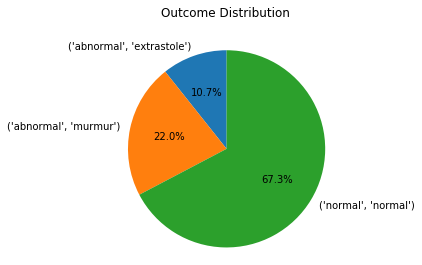

In [6]:
class_dist = train_df.groupby(['outcome','response'])['response'].count()
fig, ax = plt.subplots()
ax.set_title('Outcome Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()

### Add Audio Length

In [7]:
pd.set_option('mode.chained_assignment', None)

train_df.set_index('fname', inplace=True)
test_df.set_index('fname', inplace=True)

for f in tqdm(train_df.index):
    signal, rate = load_wav(train_wav, f)
    wav_len = librosa.get_duration(signal, rate)
    train_df.at[f, 'length'] = wav_len
    
for f in tqdm(test_df.index):
    signal, rate = load_wav(test_wav, f)
    wav_len = librosa.get_duration(signal, rate)
    test_df.at[f, 'length'] = wav_len

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:31<00:00,  4.34it/s]


In [8]:
class_dist = train_df.groupby(['outcome'])['outcome'].count()
len_min = int(train_df['length'].min() * 22050) #check the minimum length of the audio in training set
n_samples = 2 * int(train_df['length'].sum()/train_df['length'].min()) 
prob_dist = class_dist / class_dist.sum()

In [ ]:
# len_min

# Visualize Audios
### 1. Single signal plots
randomly pick one wav file

#### Wav Plot

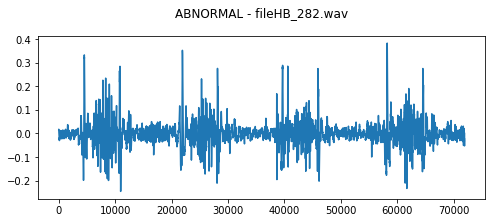

In [9]:
rand_class = np.random.choice(class_dist.index, p=prob_dist)
wav_file = np.random.choice(train_df[train_df.outcome==rand_class].index)
signal, rate = load_wav(train_wav, wav_file)
fig, ax = plt.subplots(figsize=(8,3))
ax.set_title(rand_class.upper() + ' - file' + wav_file, y=1.08)
plt.plot(signal)
plt.show()

#### Wav Audio

In [10]:
# audio for this file
Audio(data=signal, rate= rate)

#### Wav Spectrogram

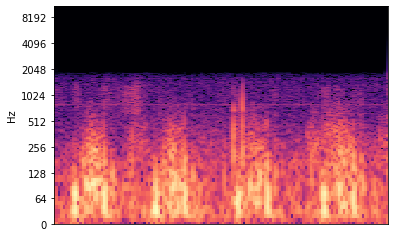

In [11]:
# spectrogram for this file
D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
librosa.display.specshow(D, y_axis='log')

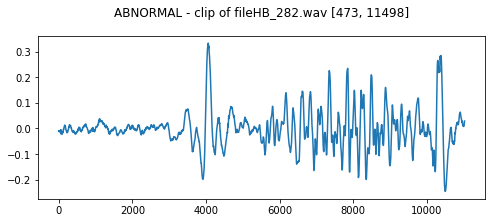

In [14]:
# randomly generate a clip of a signal
    clip_len = int(11025)
    rand_start = np.random.randint(0, signal.shape[0] - clip_len)
    rand_end = rand_start + clip_len
    fig, ax = plt.subplots(figsize=(8,3))
    ax.set_title(rand_class.upper() + ' - clip of file' + wav_file + ' [' + str(rand_start) + ', ' + str(rand_end) + ']', y=1.08)
    plt.plot(signal[rand_start:rand_end])
    plt.show()
    Audio(data=signal, rate= rate)

### 2. Two Classes Comparisons

In [15]:
title = {}
signals = {}
clipped_signals = {}
audio = {}
fft = {}
fbank={}
mfccs = {}
classes = list(np.unique(train_df.outcome))

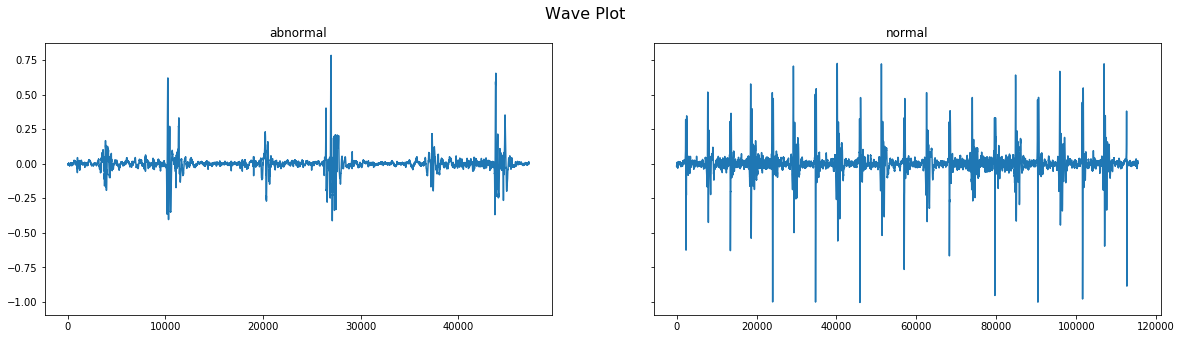

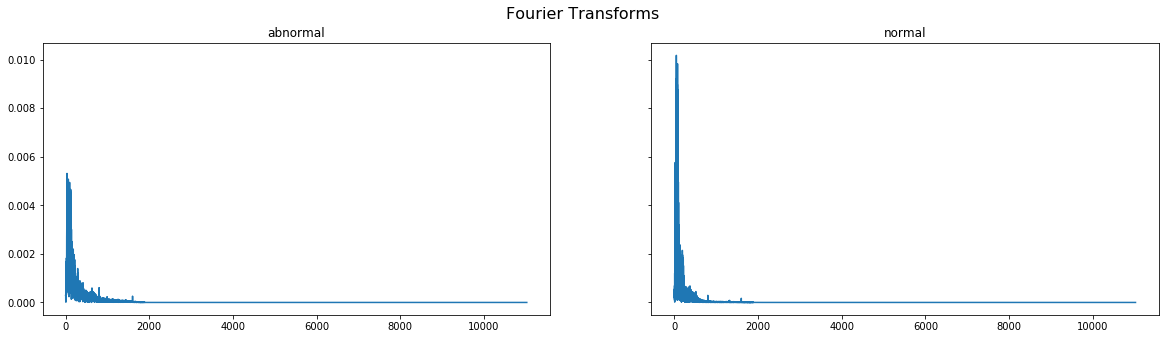

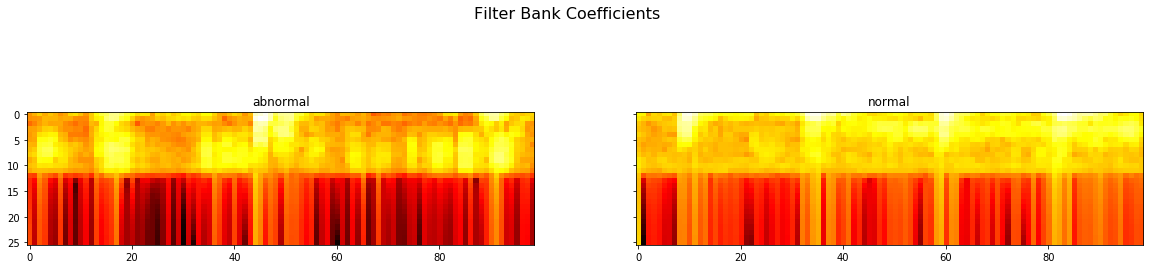

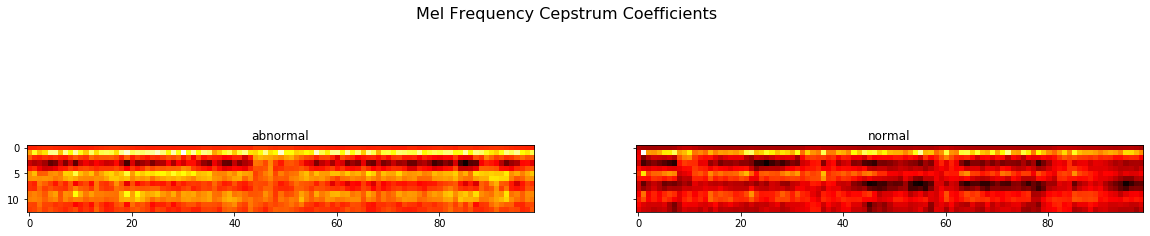

In [19]:
generate_2classes_rand(classes)
plot_signals(signals)
plot_fft(fft)
plot_fbank(fbank)
plot_mfccs(mfccs)

# Data Preprocessing

### 1. Make audios the same length

Repeating audio to given length

In [20]:
# Repeat all signals to 5 seconds and save files to a new folder
length = 110250
if len(os.listdir('train/train_sr110250')) == 0:
    for f in tqdm(train_df.index):
        signal, rate = load_wav(train_wav, f)
        signal = repeat_to_len(signal, length)
        wavfile.write(filename='train/train_sr110250/'+f, rate=rate, data=signal)

In [21]:
# For test data
length = 110250
if len(os.listdir('test/test_sr110250')) == 0:
    for f in tqdm(test_df.index):
        signal, rate = load_wav(test_wav, f)
        signal = repeat_to_len(signal, length)
        wavfile.write(filename='test/test_sr110250/'+f, rate=rate, data=signal)

### 2. Down Sampling
Downsample from 110250(original sampling rate of 22050 * 5secs) to 8000.

In [22]:
if len(os.listdir('train/train_sr8000')) == 0:
    for f in tqdm(train_df.index):
        signal, rate = librosa.load('train/train_sr110250/'+f, sr=8000)
        wavfile.write(filename='train/train_sr8000/'+f, rate=rate, data=signal)

In [23]:
if len(os.listdir('test/test_sr8000')) == 0:
    for f in tqdm(test_df.index):
        signal, rate = librosa.load('test/test_sr110250/'+f, sr=8000)
        wavfile.write(filename='test/test_sr8000/'+f, rate=rate, data=signal)

### Further: Filter out the noise
Filter the 50–800 Hz frequency to get rid of the noise in the heartbeat sound signal.

# Build Model

In [25]:
class Config:
    def __init__(self, mode, filenames, filepath):
        self.mode = mode
        self.filenames = filenames
        self.filepath = filepath
        self.model_path = os.path.join('models', mode + '.model')
        self.p_path = os.path.join('pickles', mode + '.p')

In [37]:
def get_features(filenames, wav_path, rep_len=110250, feat_len=40):
    
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    
    X = []
    spectrograms = []
    melspectrograms = []
    mfccs = []
    
    for file in tqdm(filenames):
        wav, sr = librosa.load(wav_path + file)
        
        wav_rep = repeat_to_len(wav, rep_len)
        
        spectrogram = np.abs(librosa.stft(wav))
        spectrogram_rep = repeat_to_len_2d(spectrogram, feat_len)
        
        melspectrogram = librosa.feature.melspectrogram(wav)
        melspectrogram_rep = repeat_to_len_2d(melspectrogram, feat_len)
        
        mfcc = librosa.feature.mfcc(wav)
        mfcc_rep = repeat_to_len_2d(mfcc, feat_len)

        X.append(wav_rep)
        spectrograms.append(spectrogram_rep)
        melspectrograms.append(melspectrogram_rep)
        mfccs.append(mfcc_rep)

    if config.mode == 'cnn':
        x_data_pre = np.vstack(X)
        x_data =  np.expand_dims(x_data_pre, -1)
        spectrograms = np.expand_dims(spectrograms, -1)
        melspectrograms = np.expand_dims(melspectrograms, -1)
        mfccs = np.expand_dims(mfccs, -1)
    elif config.mode == 'rnn':    
        x_data = np.vstack(X)
        spectrograms = np.array(spectrograms)
        melspectrograms = np.array(melspectrograms)
        mfccs = np.array(mfccs)
    elif config.mode == 'svm':    
        x_data = np.vstack(X)
        spectrograms = np.array(spectrograms)
        melspectrograms = np.array(melspectrograms)
        mfccs = np.array(mfccs)
        
    return x_data, spectrograms, melspectrograms, mfccs

In [97]:
one_hot = {'normal': 0, 'abnormal': 1}
y_data = np.array(train_df['outcome'].map(one_hot))

### 1. CNN Model

In [95]:
config = Config(mode='cnn', filenames=train_df.index, filepath='train/train_sr110250/')

In [96]:
x_data, spectrograms, melspectrograms, mfccs = get_features(filenames=config.filenames, wav_path=config.filepath)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:54<00:00,  5.85it/s]


In [98]:
feature = spectrograms

In [99]:
x_train, x_test, y_train, y_test, train_filenames, test_filenames = train_test_split(feature, y_data, config.filenames, test_size=0.25)

In [100]:
input_shape = x_train[0].shape

In [101]:
def cnn():
    if x_train.ndim == 3:
        cnn_model = Sequential()
        cnn_model.add(Conv1D(filters=32, kernel_size=5, activation='relu', 
                             padding='same', input_shape = input_shape))
        cnn_model.add(Conv1D(64, 10, activation='relu'))
        cnn_model.add(MaxPooling1D(pool_size=3))
        cnn_model.add(Conv1D(128, 10, activation='relu'))
        cnn_model.add(MaxPooling1D(pool_size=3))
        cnn_model.add(Dropout(0.4))
        cnn_model.add(Flatten())
        cnn_model.add(Dense(32, activation='relu'))
        cnn_model.add(Dense(1, activation='sigmoid'))
        cnn_model.summary()
        cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
        return cnn_model

    elif x_train.ndim == 4:
        cnn_model = Sequential()
        cnn_model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', 
                              padding='same', input_shape = input_shape))
        cnn_model.add(MaxPool2D(pool_size=(4,4)))
        cnn_model.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
        cnn_model.add(MaxPool2D(pool_size=(4,4)))
        cnn_model.add(Flatten())
        cnn_model.add(Dense(32, activation='relu'))
        cnn_model.add(Dense(1, activation='sigmoid'))
        cnn_model.summary()
        cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
        return cnn_model

In [102]:
cnn_model=cnn()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 1025, 40, 32)      544       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 256, 10, 32)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 253, 7, 64)        32832     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 1, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                129056    
_________________________________________________________________
dense_10 (Dense)             (None, 1)               

In [103]:
checkpoint = ModelCheckpoint(os.path.join('models', config.mode + '.model'), monitor='val_acc', mode='max', verbose=2,  
                            save_best_only=True, save_weights_only=False, period=1)
class_weight = compute_class_weight('balanced', np.unique(y_data), y_data)
class_weight = dict(zip(np.unique(y_train), class_weight))

In [104]:
cnn_hist = cnn_model.fit(x_train, y_train, epochs=20, batch_size=32,
                     validation_data=(x_test, y_test),
                     verbose=2, class_weight=class_weight, callbacks=[checkpoint])

Train on 238 samples, validate on 80 samples
Epoch 1/20
 - 7s - loss: 0.9101 - acc: 0.5336 - val_loss: 0.7910 - val_acc: 0.3375

Epoch 00001: val_acc improved from -inf to 0.33750, saving model to models\cnn.model
Epoch 2/20
 - 6s - loss: 0.6561 - acc: 0.3866 - val_loss: 0.5736 - val_acc: 0.7500

Epoch 00002: val_acc improved from 0.33750 to 0.75000, saving model to models\cnn.model
Epoch 3/20
 - 6s - loss: 0.6489 - acc: 0.7395 - val_loss: 0.6416 - val_acc: 0.6000

Epoch 00003: val_acc did not improve from 0.75000
Epoch 4/20
 - 6s - loss: 0.6192 - acc: 0.5378 - val_loss: 0.5911 - val_acc: 0.7625

Epoch 00004: val_acc improved from 0.75000 to 0.76250, saving model to models\cnn.model
Epoch 5/20
 - 7s - loss: 0.5904 - acc: 0.6555 - val_loss: 0.5888 - val_acc: 0.7625

Epoch 00005: val_acc did not improve from 0.76250
Epoch 6/20
 - 7s - loss: 0.5774 - acc: 0.7185 - val_loss: 0.6008 - val_acc: 0.6750

Epoch 00006: val_acc did not improve from 0.76250
Epoch 7/20
 - 7s - loss: 0.5664 - acc: 0

In [106]:
cnn_pred_prob = cnn_model.predict(x_test)
cnn_pred_classes = [1 if x >= 0.5 else 0 for x in cnn_pred_prob]

In [107]:
cnn_model.save(config.model_path)

### 2. RNN Model

In [108]:
config = Config(mode='rnn', filenames=train_df.index, filepath='train/train_sr110250/')

In [109]:
x_data, spectrograms, melspectrograms, mfccs = get_features(filenames=config.filenames, wav_path=config.filepath)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:55<00:00,  5.77it/s]


In [110]:
feature = spectrograms

In [111]:
x_train, x_test, y_train, y_test, train_filenames, test_filenames = train_test_split(feature, y_data, config.filenames, test_size=0.25)

In [112]:
input_shape = x_train[0].shape

In [113]:
def rnn():
    print('Build LSTM RNN model ...')
    rnn_model = Sequential()
    rnn_model.add(LSTM(64, dropout=0.05,  recurrent_dropout=0.20, return_sequences=True, input_shape=input_shape))
    rnn_model.add(LSTM(32, return_sequences=True))
    rnn_model.add(Dropout(0.35))
    rnn_model.add(Dense(8, activation='relu'))
    rnn_model.add(Flatten())
    rnn_model.add(Dense(1, activation='sigmoid'))
    rnn_model.summary()
    rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return rnn_model

In [114]:
rnn_model = rnn()

Build LSTM RNN model ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1025, 64)          26880     
_________________________________________________________________
lstm_8 (LSTM)                (None, 1025, 32)          12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1025, 32)          0         
_________________________________________________________________
dense_11 (Dense)             (None, 1025, 8)           264       
_________________________________________________________________
flatten_6 (Flatten)          (None, 8200)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 8201      
Total params: 47,761
Trainable params: 47,761
Non-trainable params: 0
________________________

In [115]:
checkpoint = ModelCheckpoint(os.path.join('models', config.mode + '.model'), monitor='val_acc', mode='max', verbose=2,  
                            save_best_only=True, save_weights_only=False, period=1)
class_weight = compute_class_weight('balanced', np.unique(y_data), y_data)

In [116]:
rnn_hist = rnn_model.fit(x_train, y_train, epochs=20, batch_size=32,
                     validation_data=(x_test, y_test),
                     verbose=2, class_weight=class_weight, callbacks=[checkpoint])

Train on 238 samples, validate on 80 samples
Epoch 1/20
 - 15s - loss: 0.6552 - acc: 0.6723 - val_loss: 0.6248 - val_acc: 0.6750

Epoch 00001: val_acc improved from -inf to 0.67500, saving model to models\rnn.model
Epoch 2/20
 - 13s - loss: 0.6012 - acc: 0.6765 - val_loss: 0.5927 - val_acc: 0.7250

Epoch 00002: val_acc improved from 0.67500 to 0.72500, saving model to models\rnn.model
Epoch 3/20
 - 13s - loss: 0.5617 - acc: 0.7521 - val_loss: 0.5459 - val_acc: 0.7625

Epoch 00003: val_acc improved from 0.72500 to 0.76250, saving model to models\rnn.model
Epoch 4/20
 - 12s - loss: 0.4930 - acc: 0.7689 - val_loss: 0.5522 - val_acc: 0.7500

Epoch 00004: val_acc did not improve from 0.76250
Epoch 5/20
 - 12s - loss: 0.4625 - acc: 0.7731 - val_loss: 0.6152 - val_acc: 0.7375

Epoch 00005: val_acc did not improve from 0.76250
Epoch 6/20
 - 12s - loss: 0.4087 - acc: 0.8109 - val_loss: 0.6381 - val_acc: 0.6875

Epoch 00006: val_acc did not improve from 0.76250
Epoch 7/20
 - 13s - loss: 0.3536 -

In [118]:
rnn_pred_prob = rnn_model.predict(x_test)
rnn_pred_classes = [1 if x >= 0.5 else 0 for x in rnn_pred_prob]

In [119]:
rnn_model.save(config.model_path)

### 3. SVM Model

In [120]:
config = Config(mode='svm', filenames=train_df.index, filepath='train/train_sr110250/')

In [121]:
x_data, spectrograms, melspectrograms, mfccs = get_features(filenames=config.filenames, wav_path=config.filepath)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:53<00:00,  5.94it/s]


In [122]:
feature = x_data

In [123]:
x_train, x_test, y_train, y_test, train_filenames, test_filenames = train_test_split(feature, y_data, config.filenames, test_size=0.25)

In [124]:
svm_model = SVC(kernel='rbf', C=1.0)
svm_model.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [125]:
svm_pred_prob = svm_model.predict(x_test)
svm_pred_classes = [1 if x >= 0.5 else 0 for x in svm_pred_prob]

In [127]:
svm_model.save(config.model_path)

AttributeError: 'SVC' object has no attribute 'save'

# Prediction

In [137]:
test_files = test_df.index
test_wav_path = 'test/test_sr110250/'

In [149]:
config = Config(mode='cnn', filenames=test_files, filepath=test_wav_path)

In [150]:
x_data_test, test_spectrograms, test_melspectrograms, test_mfccs = get_features(filenames=test_files, wav_path=test_wav_path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:23<00:00,  5.84it/s]


In [151]:
feature = test_spectrograms

In [152]:
#CNN
cnn_y_pred = cnn_model.predict(feature)
cnn_y_pred = cnn_y_pred.flatten().tolist()
cnn_pred_output = pd.DataFrame(list(zip(test_files, cnn_y_pred)), columns =['fname', 'outcome']) 
cnn_pred_output.to_csv('cnn_pred.csv', index=False)

In [157]:
config = Config(mode='rnn', filenames=test_files, filepath=test_wav_path)

In [159]:
x_data_test, test_spectrograms, test_melspectrograms, test_mfccs = get_features(filenames=test_files, wav_path=test_wav_path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:22<00:00,  6.08it/s]


In [160]:
#RNN
rnn_y_pred = rnn_model.predict(feature)
rnn_y_pred = rnn_y_pred.flatten().tolist()
rnn_pred_output = pd.DataFrame(list(zip(test_files, rnn_y_pred)), columns =['fname', 'outcome']) 
rnn_pred_output.to_csv('rnn_pred.csv', index=False)

ValueError: Error when checking input: expected lstm_7_input to have 3 dimensions, but got array with shape (139, 1025, 40, 1)

In [161]:
config = Config(mode='svm', filenames=test_files, filepath=test_wav_path)

In [162]:
x_data_test, test_spectrograms, test_melspectrograms, test_mfccs = get_features(filenames=test_files, wav_path=test_wav_path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:23<00:00,  5.87it/s]


In [163]:
#SVM
svm_y_pred = svclassifier.predict(x_data_test)
svm_y_pred = svm_y_pred.flatten().tolist()
svm_pred_output = pd.DataFrame(list(zip(test_files, svm_y_pred)), columns =['fname', 'outcome']) 
svm_pred_output.to_csv('svm_pred.csv', index=False)